# Libraries

In [171]:
#python libraries
import math

#Data Manipulation
import pandas as pd
import numpy as np

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#Data modeling
from lightgbm import LGBMRegressor

#statistical libraries
from scipy.stats import shapiro

#time series
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Functions

In [24]:
# function (1): that plot the distribution and probplot of the data and check if 
# has a gaussian distribution
def check_distribution(df): 
    columns = df.select_dtypes(include=np.number)
    
    for i,col in enumerate(columns):
        
        
        
        stat, p_value_norm = shapiro(df[col])
        print(f'Distribution for {col}:')
        print('stat=%.3f, p=%.3f' % (stat, p_value_norm))
        
        if p_value_norm > 0.05 : 
            print("The data from {} is normally distributed".format(col))
            txt = "The data from {} is normally distributed with stat=%.3f, p=%.3f".format(col,stat, p_value_norm)
            
        else: 
            print("The data from {} is not normally distributed".format(col))
            txt = "The data from {} is not normally distributed with stat={:0.3f}, p={:0.3f}".format(col,stat, p_value_norm)
            
            
            
        print('----------------------------------------------------------------------------------------------')

        fig,axes= plt.subplots(1,2,figsize=(8, 5))
        plt.suptitle(col, fontsize=18, y=1,fontweight="bold")
        sns.histplot(data = df, x=col,kde=True,ax=axes[0])
        sm.qqplot(df[col], line ='45',ax=axes[1])
        axes[0].set_title("Distribution Plot",weight = 'bold')
        axes[1].set_title("QQ Plot",weight = 'bold')
        plt.figtext(0.5,-0.05,txt,horizontalalignment ="center",fontsize = 10,fontweight="bold")
        plt.tight_layout()
        plt.show()

In [49]:
#function (2) lineplot of the features by date  

def plot_cols(df,n_column,title): 
    
    columns = df.columns
    
    rows = math.ceil(len(columns)/n_column)
    
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle(title, fontsize=18, y= 1)

    for n, col in enumerate(columns):
        ax = plt.subplot(rows,n_column, n + 1)
        
        fig = sns.lineplot(data = df, x=df.index, y=col)
        plt.xticks(rotation=15,weight = 'bold')

    plt.tight_layout()
    plt.show()
    

# Load Data

In [15]:
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv')

data = pd.read_csv(url)

In [16]:
#drop the date column
data.drop(columns='Date',inplace=True)

In [17]:
data.head()

,Time,Demand,Temperature,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,True


The column containing the time series is read as a string and the change to date format must be made, it have the format in  UTC Time YYYYY-MM-DD-THH:MM:SZ

In [18]:
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data.head()

,Demand,Temperature,Holiday
Time,,,
2011-12-31 13:00:00,4382.825174,21.40,True
2011-12-31 13:30:00,4263.365526,21.05,True
2011-12-31 14:00:00,4048.966046,20.70,True
2011-12-31 14:30:00,3877.563330,20.55,True
2011-12-31 15:00:00,4036.229746,20.40,True


# DEA

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52608 entries, 2011-12-31 13:00:00 to 2014-12-31 12:30:00
Freq: 30T
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand       52608 non-null  float64
 1   Temperature  52608 non-null  float64
 2   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2)
memory usage: 1.3 MB


In [20]:
#check missing values
data.isnull().sum()

Demand         0
Temperature    0
Holiday        0
dtype: int64

In [21]:
#check if the time series is complete, as there is a time range we need the sime series continuity

check_range = pd.date_range(start= data.index.min(),end= data.index.max(),freq=data.index.freq)
check_range

DatetimeIndex(['2011-12-31 13:00:00', '2011-12-31 13:30:00',
               '2011-12-31 14:00:00', '2011-12-31 14:30:00',
               '2011-12-31 15:00:00', '2011-12-31 15:30:00',
               '2011-12-31 16:00:00', '2011-12-31 16:30:00',
               '2011-12-31 17:00:00', '2011-12-31 17:30:00',
               ...
               '2014-12-31 08:00:00', '2014-12-31 08:30:00',
               '2014-12-31 09:00:00', '2014-12-31 09:30:00',
               '2014-12-31 10:00:00', '2014-12-31 10:30:00',
               '2014-12-31 11:00:00', '2014-12-31 11:30:00',
               '2014-12-31 12:00:00', '2014-12-31 12:30:00'],
              dtype='datetime64[ns]', length=52608, freq='30T')

In [22]:
(data.index == check_range).all()

True

The time series is in half hour periods, it is better to make a change to hour.

In [32]:
df = data.resample(rule='H', closed='left', label ='right').mean()
df.head()

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0


/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Distribution for Demand:
stat=0.973, p=0.000
The data from Demand is not normally distributed
----------------------------------------------------------------------------------------------


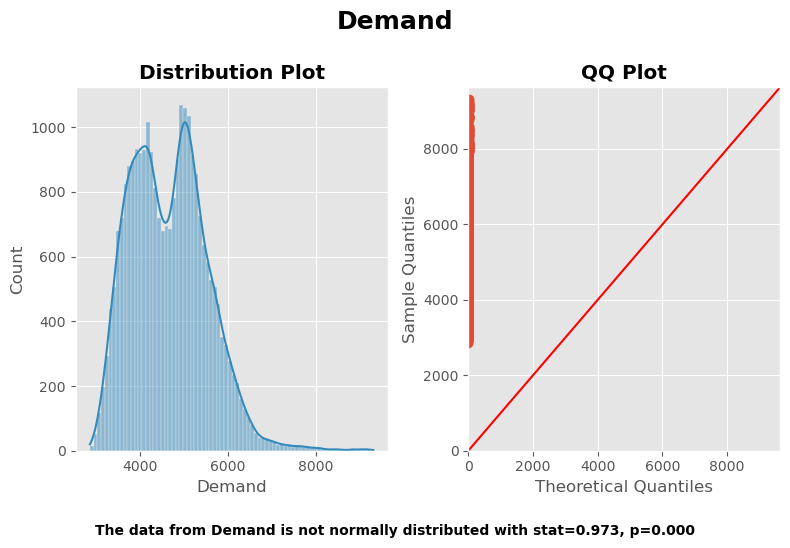

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Distribution for Temperature:
stat=0.962, p=0.000
The data from Temperature is not normally distributed
----------------------------------------------------------------------------------------------


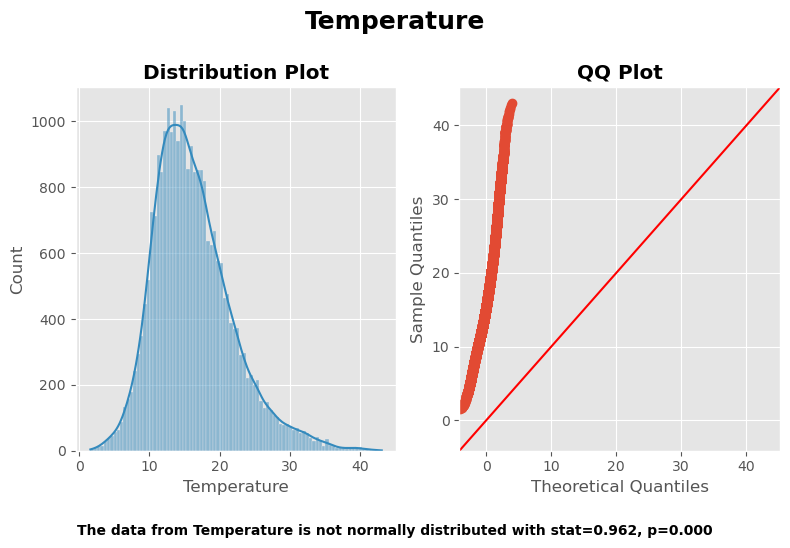

/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Distribution for Holiday:
stat=0.153, p=0.000
The data from Holiday is not normally distributed
----------------------------------------------------------------------------------------------


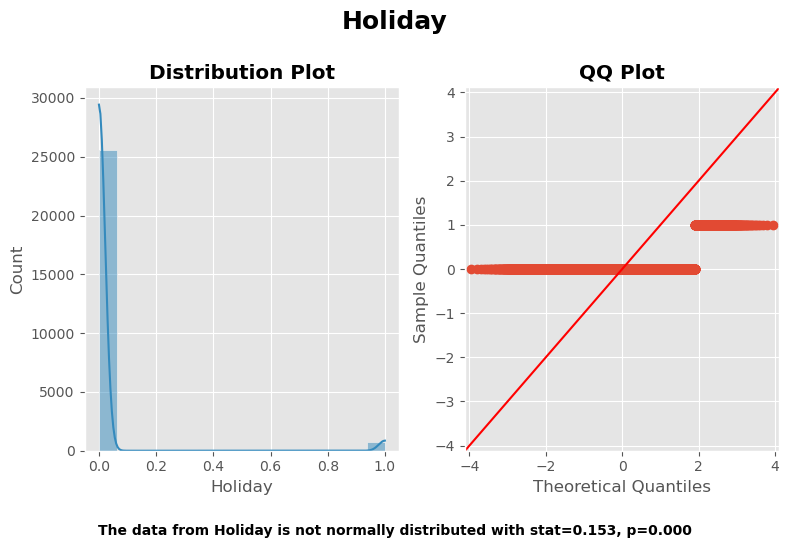

In [35]:
check_distribution(df)

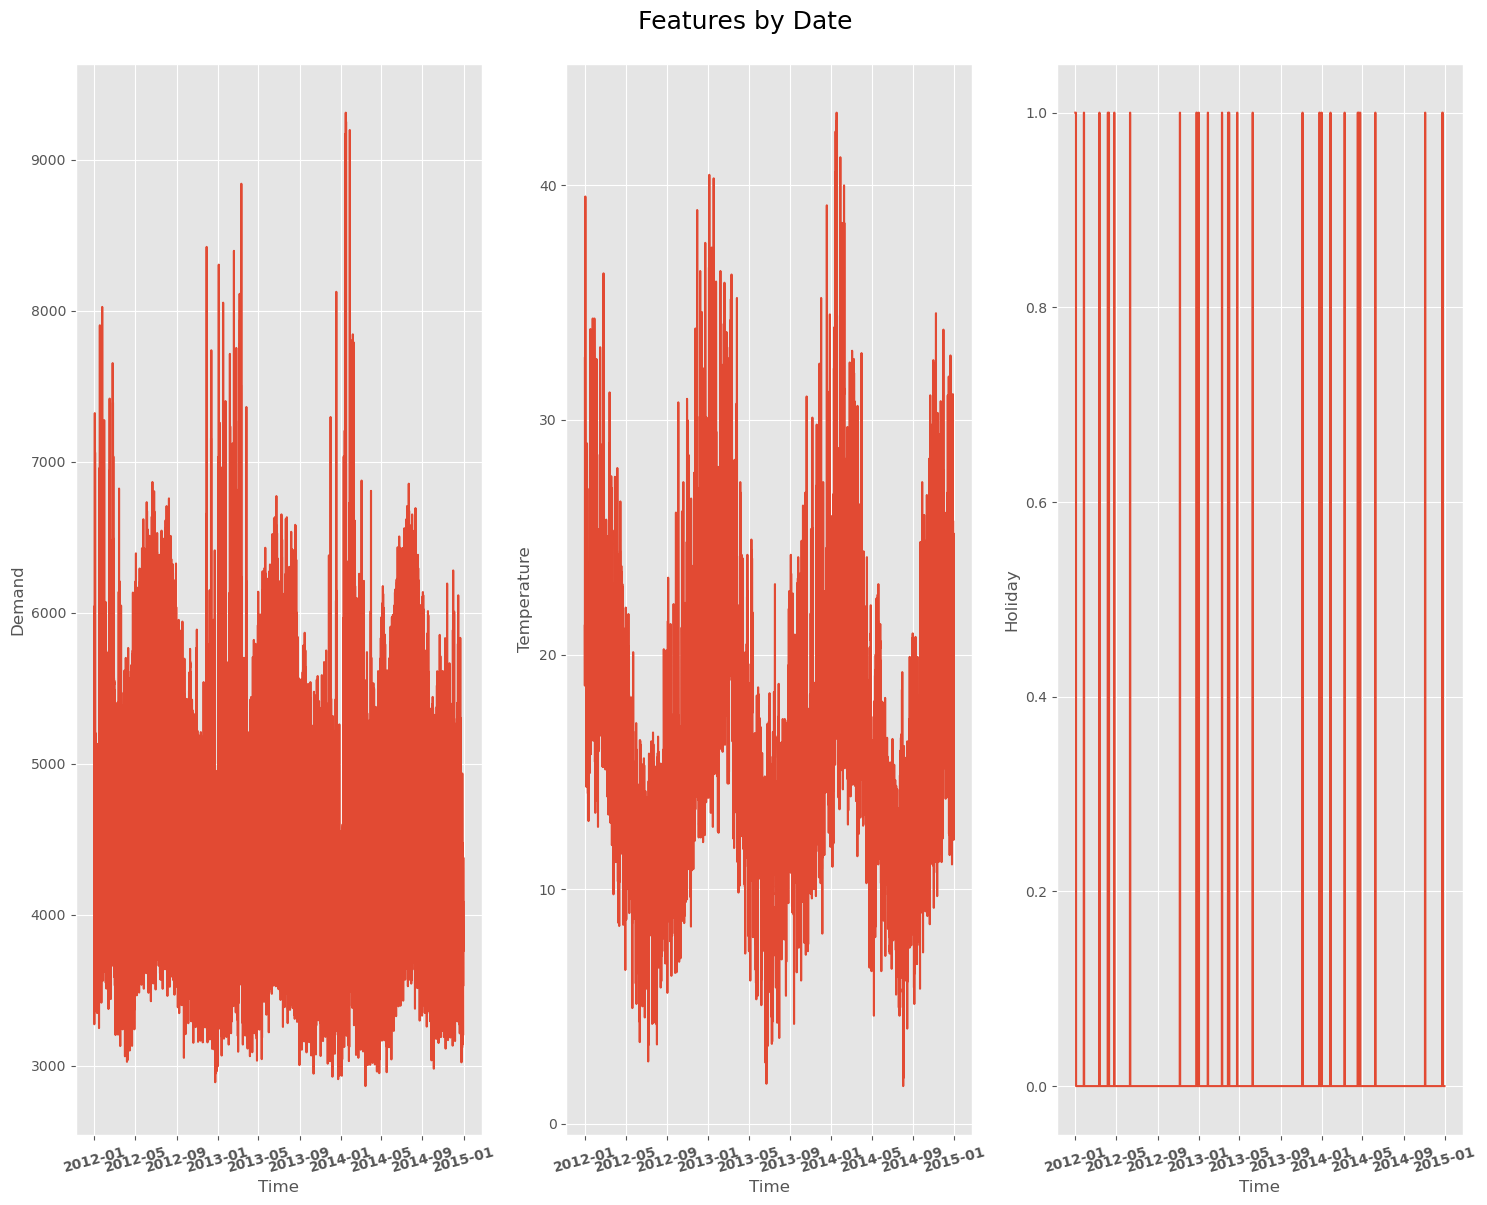

In [51]:
#use function (2) to plot the features by date
plot_cols(df,3,"Features by Date",)

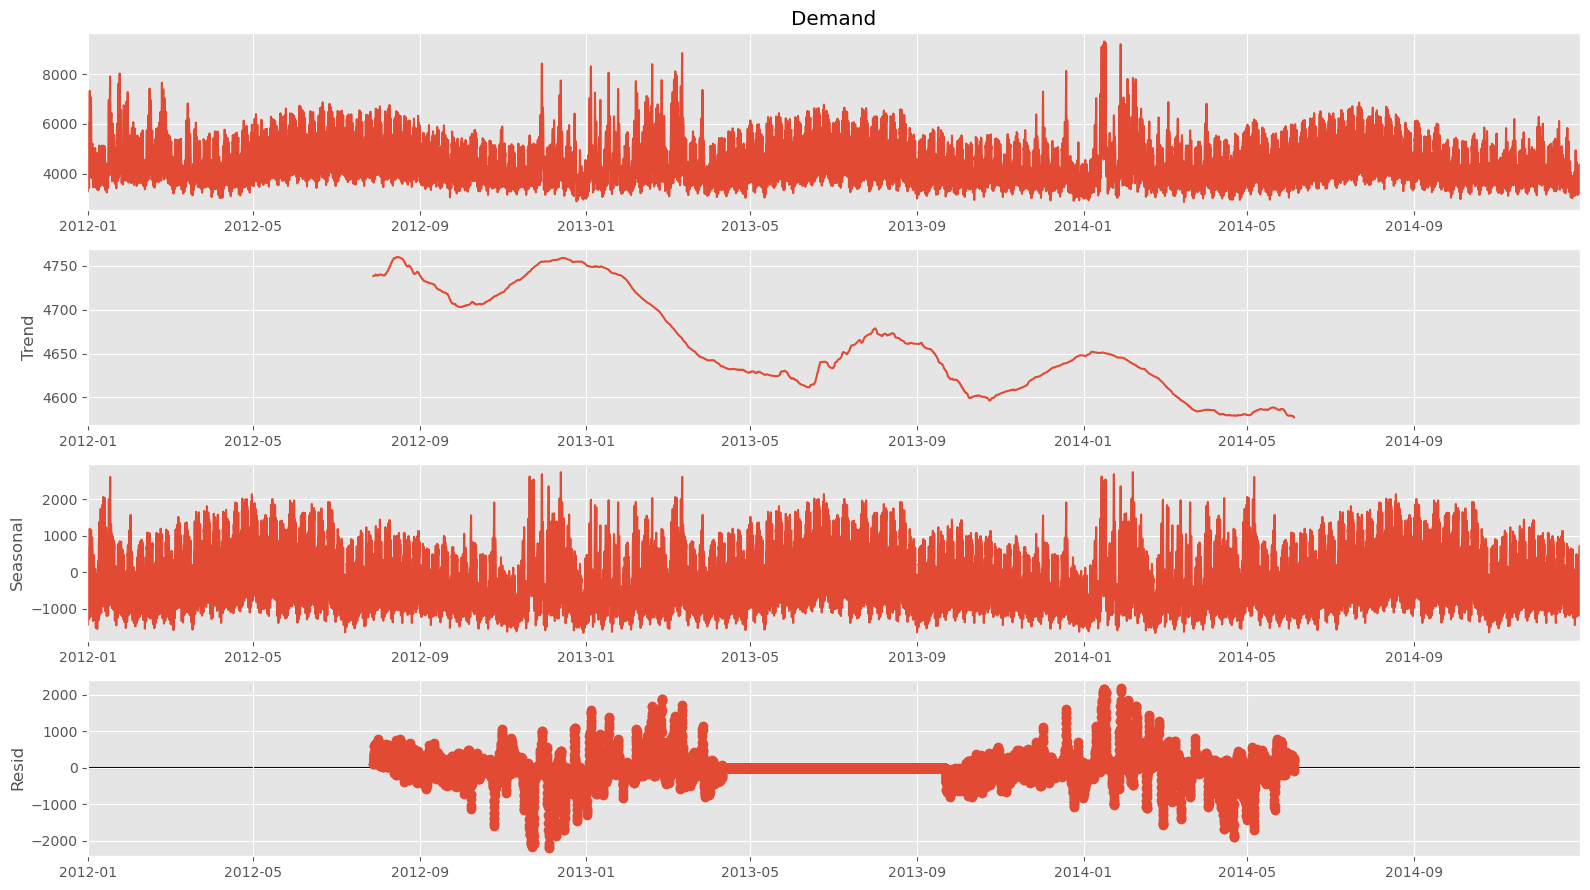

In [124]:
# Descomposición de series temporales

decomposition = seasonal_decompose(df['Demand'], period=10080,model='additive') 
fig = decomposition.plot()
fig.set_size_inches((16, 9))
plt.tight_layout()
plt.show()

In [125]:
ad_fuller_result = adfuller(df["Demand"])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}') 

ADF Statistic: -15.746638473361285
p-value: 1.2374523457909444e-28


In [80]:
if ad_fuller_result[1] < .05:
    print("Stationary")
else: 
    print("No-Stationary")

Stationary


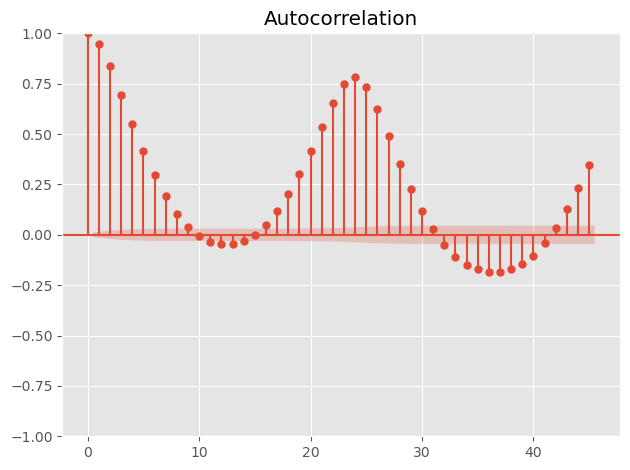

In [131]:
sm.graphics.tsa.plot_acf(df["Demand"])
plt.tight_layout()
plt.show()

# Split Data

In [146]:
new_range_df = df.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_val = '2014-11-30 23:59:00'
df_train = new_range_df.loc[: end_train, :]
df_val   = new_range_df.loc[end_train:end_val, :]
df_test  = new_range_df.loc[end_val:, :]

print(f"Train date: {df_train.index.min()} to {df_train.index.max()} (n={len(df_train)})")
print(f"Val date: {df_val.index.min()} to {df_val.index.max()} (n={len(df_val)})")
print(f"Test date: {df_test.index.min()} to {df_test.index.max()} (n={len(df_test)})")

Train date: 2012-01-01 00:00:00 to 2013-12-31 23:00:00 (n=17544)
Val date: 2014-01-01 00:00:00 to 2014-11-30 23:00:00 (n=8016)
Test date: 2014-12-01 00:00:00 to 2014-12-30 23:00:00 (n=720)


The time series data covers fractions of months both at the beginning and at the end, these will be discarded.

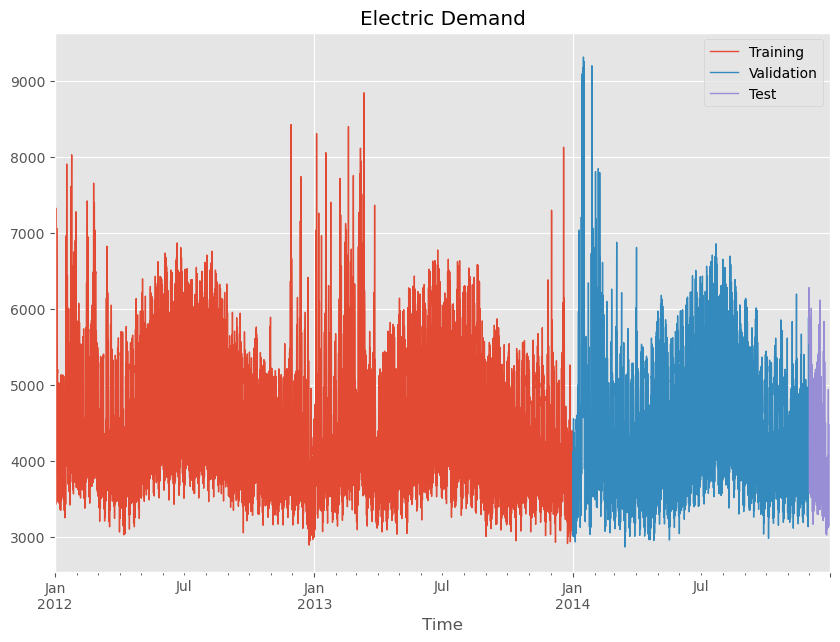

In [150]:
fig, ax = plt.subplots(figsize=(10, 7))
df_train.Demand.plot(ax=ax, label='Training', linewidth=1)
df_val.Demand.plot(ax=ax, label='Validation', linewidth=1)
df_test.Demand.plot(ax=ax, label='Test', linewidth=1)
ax.set_title('Electric Demand')
ax.legend()
plt.show()

In [174]:
forecaster = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(random_state=17),
                 steps            = 112, # Steps + gap
                 lags             = 24, # Este valor será remplazado en el grid search
                 transformer_y    = None,
                 transformer_exog = None
             )

# Lags utilizados como predictores
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

exog = ["Temperature","Holiday"]
grid = grid_search_forecaster(
                      forecaster            = forecaster,
                      y                     = data.loc[:end_val, 'Demand'],
                      exog                  = data.loc[:end_val, exog],
                      steps                 = 100,
                      metric                = 'mean_absolute_error',
                      param_grid            = param_grid,
                      lags_grid             = lags_grid,
                      initial_train_size    = len(data.loc[:end_train])+12,
                      gap                   = 12,
                      allow_incomplete_fold = True,
                      refit                 = False,
                      return_best           = True,
                      verbose               = False
                  )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'max_depth': 6, 'n_estimators': 500}
  Backtesting metric: 347.9977855022493



In [177]:
grid

,lags,params,mean_absolute_error,max_depth,n_estimators
7,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 6, 'n_estimators': 500}",347.997786,6,500
5,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 4, 'n_estimators': 500}",357.239273,4,500
6,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 6, 'n_estimators': 100}",364.972084,6,100
4,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 4, 'n_estimators': 100}",386.525760,4,100
3,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 500}",395.172292,6,500
1,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 500}",405.502516,4,500
2,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 100}",415.208411,6,100
0,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 100}",434.804654,4,100


In [175]:
metrics, predictions = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = data['Demand'],
                            exog                  = data[exog],
                            steps                 = 100,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(data.loc[:end_val])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            verbose               = False,
                            show_progress         = True  
                        )

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=ValueTypesExogWarning)
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/skforecast/utils/utils.py:346: DataTypeWarning: `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning models do not allow other types of values. Fitting the forecaster may fail. 
 You can 

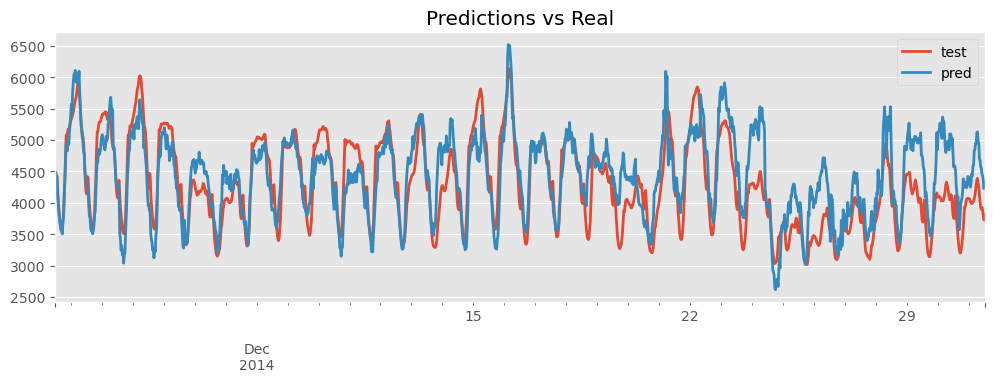

In [176]:
fig, ax = plt.subplots(figsize=(12, 3.5))
data.loc[predictions.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predictions.plot(linewidth=2, label='Predictions', ax=ax)
ax.set_title('Predictions vs Real')
ax.legend()
plt.show()